IMPORTATION DES BIBLIOTHEQUES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
import seaborn as sns
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import PolynomialFeatures


IMPORTATION DES DONNEES

In [5]:
x_train = pd.read_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\x_train_final.csv")
y_train = pd.read_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\y_train_final_j5KGWWK.csv")
x_test = pd.read_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\x_test_final.csv")  # Fichier test

y_train = y_train.iloc[:, -1]  # Prendre uniquement la colonne cible



CREATION DE NOUVELLES FEATURES

In [ ]:
def new_data(X):
    new_data = X.copy()
    
    # ✅ Encodage label des noms de gares et trains
    for col in ["train", "gare", "arret"]:
        le = LabelEncoder()
        new_data[col] = le.fit_transform(new_data[col])

    if 'date' in new_data.columns:
        new_data['date'] = pd.to_datetime(new_data['date']).astype(int) / 10**9  

    # ✅ Statistiques globales
    pq_cols = ["p2q0", "p3q0", "p4q0"]
    qp_cols = ["p0q2", "p0q3", "p0q4"]

    new_data["mean_pq"] = new_data[pq_cols].mean(axis=1)
    new_data["mean_qp"] = new_data[qp_cols].mean(axis=1)
    new_data["var_pq"] = new_data[pq_cols].var(axis=1)
    new_data["var_qp"] = new_data[qp_cols].var(axis=1)
    new_data["std_pq"] = new_data[pq_cols].std(axis=1)
    new_data["std_qp"] = new_data[qp_cols].std(axis=1)

    new_data["acceleration_retard"] = (new_data["p3q0"] - new_data["p4q0"]) - (new_data["p2q0"] - new_data["p3q0"])

    # ✅ Moyennes et Variances par train/gare/arret
    for group in ["train", "gare", "arret"]:
        for stat in ["mean", "var", "std"]:
            new_data[f"{group}_{stat}_pq"] = new_data.groupby(group)["mean_pq"].transform(stat)
            new_data[f"{group}_{stat}_qp"] = new_data.groupby(group)["mean_qp"].transform(stat)

        new_data[f"{group}_diff_pq"] = new_data[f"{group}_mean_pq"] - new_data["mean_pq"]
        new_data[f"{group}_diff_qp"] = new_data[f"{group}_mean_qp"] - new_data["mean_qp"]

    # ✅ Interactions entre variables catégorielles
    new_data["train_gare"] = new_data["train"] * new_data["gare"]
    new_data["train_arret"] = new_data["train"] * new_data["arret"]
    new_data["gare_arret"] = new_data["gare"] * new_data["arret"]

    # ✅ Combinaisons mathématiques
    new_data["p2q0_p3q0_sum"] = new_data["p2q0"] + new_data["p3q0"]
    new_data["p2q0_p3q0_prod"] = new_data["p2q0"] * new_data["p3q0"]
    new_data["p3q0_p4q0_prod"] = new_data["p3q0"] * new_data["p4q0"]
    
    new_data["p2q0_ratio_p3q0"] = new_data["p2q0"] / (new_data["p3q0"] + 1e-6)
    new_data["mean_pq_qp_prod"] = new_data["mean_pq"] * new_data["mean_qp"]
    new_data["mean_pq_ratio_qp"] = new_data["mean_pq"] / (new_data["mean_qp"] + 1e-6)

    new_data["trend_pq"] = (new_data["p2q0"] + 2 * new_data["p3q0"] + 3 * new_data["p4q0"]) / 6

    # ✅ Transformations mathématiques (log, sqrt, exp)
    for col in ["mean_pq", "mean_qp", "var_pq", "var_qp"]:
        new_data[f"log_{col}"] = np.log1p(new_data[col])
        new_data[f"sqrt_{col}"] = np.sqrt(new_data[col])
        new_data[f"exp_{col}"] = np.exp(new_data[col] / (new_data[col].max() + 1e-6))

    # ✅ Produits croisés entre toutes les variables numériques
    num_cols = pq_cols + qp_cols + ["mean_pq", "mean_qp", "var_pq", "var_qp", "std_pq", "std_qp"]
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            col1, col2 = num_cols[i], num_cols[j]
            new_data[f"{col1}_x_{col2}"] = new_data[col1] * new_data[col2]

    # ✅ Génération automatique de polynômes (degré 3)
    poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(new_data[num_cols])
    poly_feature_names = poly.get_feature_names_out(num_cols)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=new_data.index)

    # Fusionner avec les features originales
    new_data = pd.concat([new_data, poly_df], axis=1)

    return new_data

# 🔥 Générer les nouvelles features
new_data_train = new_data(x_train)
new_data_test = new_data(x_test)

print(f"Nombre total de features : {new_data_train.shape[1]}")



In [7]:
# Initialisation du modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)

new_data_train = pd.DataFrame(new_data_train)  # Si ce n'est pas déjà un DataFrame
y_train = np.array(y_train).ravel()  # S'assurer que y_train est bien un tableau 1D
print(f"Shape de new_data_train : {new_data_train.shape}")
print(f"Shape de y_train : {y_train.shape}")

new_data_train_split, new_data_val, y_train_split, y_val = train_test_split(new_data_train, y_train, test_size=0.2, random_state=42)

# Entraînement du modèle
#rf_model.fit(new_data_train_split, y_train_split)
#y_pred = rf_model.predict(new_data_val)

#mae = mean_absolute_error(y_val, y_pred)
#print(mae)


# 1️⃣ Diviser les données en train-test
new_data_train_split, new_data_val, y_train_split, y_val = train_test_split(new_data_train, y_train, test_size=0.2, random_state=42)


# 3️⃣ Appliquer la cross-validation sur les données d'entraînement (train split)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Calculer les scores de la cross-validation (ici MAE négatif pour avoir des valeurs positives)
cv_scores = cross_val_score(rf_model, new_data_train_split, y_train_split, cv=kf, scoring='neg_mean_absolute_error')

# Affichage des scores de chaque fold
print(f"Scores de la cross-validation : {-cv_scores}")
print(f"MAE moyen : {-cv_scores.mean():.4f}")

# 4️⃣ Réentraîner le modèle sur l'ensemble des données d'entraînement
rf_model.fit(new_data_train_split, y_train_split)

# 5️⃣ Prédiction sur les données de validation
y_val_pred = rf_model.predict(new_data_val)

# 6️⃣ Calcul de la MAE sur les données de validation
mae_val = mean_absolute_error(y_val, y_val_pred)
print(f"MAE sur les données de validation : {mae_val:.4f}")


Shape de new_data_train : (667264, 29)
Shape de y_train : (667264,)
Scores de la cross-validation : [0.8100317  0.81256568 0.81153459 0.80663367 0.81945245]
MAE moyen : 0.8120
MAE sur les données de validation : 0.8007


In [10]:
new_data_train_split, new_data_val, y_train_split, y_val = train_test_split(new_data_train, y_train, test_size=0.2, random_state=42)

# 📌 Définir la fonction d’optimisation
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),  # Convertir en entier
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=42,
        n_jobs=-1  # Utiliser tous les cœurs du processeur
    )
    return np.mean(cross_val_score(rf, new_data_train_split, y_train_split, cv=3, scoring='neg_mean_absolute_error'))

# 📌 Définir les bornes des hyperparamètres
param_bounds = {
    'n_estimators': (75, 90),   # Nombre d'arbres
    'max_depth': (5, 50),        # Profondeur max
    'min_samples_split': (2, 10),  # Nombre min d'échantillons pour un split
    'min_samples_leaf': (1, 5)     # Nombre min d'échantillons dans une feuille
}

# 📌 Exécuter l'optimisation bayésienne
optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=3, n_iter=8)  # 5 essais aléatoires puis 20 itérations

# 📌 Récupérer les meilleurs hyperparamètres
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

print("📌 Meilleurs hyperparamètres trouvés :", best_params)

# 📌 Entraîner le modèle avec les meilleurs hyperparamètres
best_rf = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(new_data_train_split, y_train_split)

# 📌 Prédictions sur les données de validation
y_val_pred = best_rf.predict(new_data_val)

# 📌 Évaluation avec la MAE
mae_val = mean_absolute_error(y_val, y_val_pred)
print(f"📌 MAE finale sur le set de validation : {mae_val:.4f}")


|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.731    | 21.85     | 4.803     | 7.856     | 83.98     |
| 2         | -0.7916   | 12.02     | 1.624     | 2.465     | 87.99     |
| 3         | -0.7263   | 32.05     | 3.832     | 2.165     | 89.55     |
| 4         | -0.7286   | 22.16     | 4.718     | 7.475     | 84.32     |
| 5         | -0.7248   | 31.24     | 4.853     | 5.487     | 79.99     |
| 6         | -0.7324   | 30.47     | 1.043     | 9.812     | 89.14     |
| 7         | -0.7255   | 45.33     | 4.131     | 2.769     | 81.55     |
| 8         | -0.7264   | 48.57     | 3.844     | 9.897     | 89.85     |
| 9         | -0.7352   | 49.55     | 1.577     | 9.823     | 75.57     |
| 10        | -0.7393   | 43.06     | 1.57      | 2.388     | 89.87     |
| 11        | -0.7397   | 39.39     | 1.212     | 2.593     | 75.4      |
📌 Meilleurs hyperparamètres trouvés : 

C:\Users\victo\AppData\Local\Temp\ipykernel_22512\3141248344.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis", hue=None)


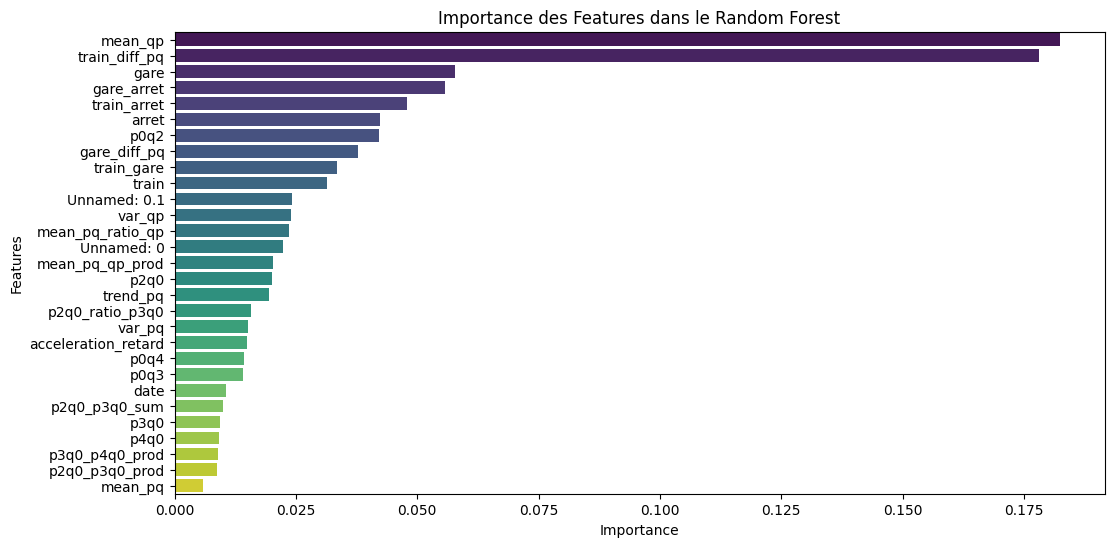

In [12]:
# Récupérer l'importance des features
feature_importance = best_rf.feature_importances_

# Créer un DataFrame pour trier les features par importance
feature_importance_df = pd.DataFrame({
    'Feature': new_data_train_split.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Affichage sous forme de barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df["Importance"], y=feature_importance_df["Feature"], palette="viridis", hue=None)

plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Importance des Features dans le Random Forest")

plt.show()

In [26]:
best_rf.fit(new_data_train.drop(columns=[new_data_train.columns[0]]), y_train)
Y_test = best_rf.predict(new_data_test)

# Appliquer np.round() pour arrondir les prédictions du test
y_pred_test = np.round(Y_test)

# Sauvegarder les prédictions dans un fichier CSV
output = pd.DataFrame({'': x_test.index, 'p0q0': y_pred_test.astype(int)})  # Conversion en int
output.to_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\predictions.csv", index=False)


In [ ]:
print(f"Shape new_data_train : {new_data_train.shape}")
print(f"Shape new_data_test : {new_data_test.shape}")

print(f"Shape new_data_train : {x_train.shape}")
print(f"Shape new_data_test : {x_test.shape}")





Shape new_data_train : (667264, 29)
Shape new_data_test : (20657, 28)
Shape new_data_train : (667264, 12)
Shape new_data_test : (20657, 11)


In [25]:
new_data_train.to_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\train.csv", index=False)
new_data_test.to_csv(r"C:\Users\victo\Desktop\IMTatlantique\data_challenge\important\test.csv", index=False)